# GRPO: Model Comparison (Before vs After Training) - 50 Epochs

In [1]:
from __future__ import annotations

import os
import re
import time
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest

os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_colwidth", 140)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 120)


/home/shamika/miniconda3/envs/ml311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
SEED = 0

def seed_everything(seed: int = 0) -> None:
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.bfloat16 if DEVICE.type == "cuda" else torch.float32
print("DEVICE:", DEVICE)
print("DTYPE :", DTYPE)
if DEVICE.type == "cuda":
    print("GPU  :", torch.cuda.get_device_name(0))
    print("VRAM :", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2), "GiB")


DEVICE: cuda
DTYPE : torch.bfloat16
GPU  : NVIDIA GeForce RTX 3060 Laptop GPU
VRAM : 6.0 GiB


In [ ]:
def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "grpo_homework.py").exists() and (p / "models").exists() and (p / "gsm8k").exists():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd().resolve())
OUTPUT_DIR = PROJECT_ROOT / "notebooks"
DATASET_PATH = PROJECT_ROOT / "gsm8k"

BASE_MODEL_PATH = PROJECT_ROOT / "models" / "Qwen2.5-1.5B-Instruct"
FT_MODEL_CANDIDATES = [PROJECT_ROOT / "saved_model"]
FT_MODEL_PATH = next((p for p in FT_MODEL_CANDIDATES if p.exists()), None)

assert BASE_MODEL_PATH.exists(), f"Base model not found: {BASE_MODEL_PATH.resolve()}"
assert FT_MODEL_PATH is not None, f"Fine-tuned model not found. Tried: {[str(p) for p in FT_MODEL_CANDIDATES]}"
assert DATASET_PATH.exists(), f"GSM8K dataset folder not found: {DATASET_PATH.resolve()}"

print("PROJECT_ROOT         :", PROJECT_ROOT)
print("Base checkpoint      :", BASE_MODEL_PATH)
print("Fine-tuned checkpoint:", FT_MODEL_PATH)


# Evaluation settings
EVAL_SPLIT = "test"
N_EXAMPLES = 200
PROMPT_MAX_LENGTH = 512

BATCH_SIZE = 2 if DEVICE.type == "cuda" else 1
MAX_NEW_TOKENS = 128

# Sampling settings (Pass@k / Self-consistency)
TEMPERATURE = 0.7
TOP_P = 0.95
K_MAX = 8
K_LIST = [1, 2, 4, 8]

assert max(K_LIST) <= K_MAX
print("BATCH_SIZE     :", BATCH_SIZE)
print("MAX_NEW_TOKENS :", MAX_NEW_TOKENS)
print("K_MAX          :", K_MAX)


PROJECT_ROOT         : /home/shamika/documents/prog_workspace/grpo_training_for_mathematical_reasoning
Base checkpoint      : /home/shamika/documents/prog_workspace/grpo_training_for_mathematical_reasoning/models/Qwen2.5-1.5B-Instruct
Fine-tuned checkpoint: /home/shamika/documents/prog_workspace/grpo_training_for_mathematical_reasoning/saved_model
BATCH_SIZE     : 2
MAX_NEW_TOKENS : 128
K_MAX          : 8


## Dataset + prompt template

We evaluate on GSM8K and use the same prompt style as the homework training script:

```
Question: ...
Answer: Let's solve this step by step.
```

Ground-truth GSM8K answers end with a line like `#### 42`, which we parse as the numeric target.

In [4]:
def extract_gsm8k_gt(answer_str: str):
    m = re.search(r"####\s*([-+]?\d+[\d,]*\.?\d*)", answer_str)
    if not m:
        return None
    return float(m.group(1).replace(",", ""))

def format_prompt(question: str) -> str:
    return f"Question: {question}\nAnswer: Let's solve this step by step.\n"

raw = load_dataset(str(DATASET_PATH), "main", split=EVAL_SPLIT)
df = pd.DataFrame({
    "question": raw["question"],
    "answer_str": raw["answer"],
})
df["gt_answer"] = df["answer_str"].apply(extract_gsm8k_gt)
df = df[df["gt_answer"].notna()].reset_index(drop=True)
df["prompt"] = df["question"].apply(format_prompt)

if N_EXAMPLES is not None and N_EXAMPLES < len(df):
    eval_df = df.sample(n=N_EXAMPLES, random_state=SEED).reset_index(drop=True)
else:
    eval_df = df.copy()

print(f"GSM8K split: {EVAL_SPLIT} | total={len(df)} | eval={len(eval_df)}")
eval_df.head(3)


GSM8K split: test | total=1319 | eval=200


,question,answer_str,gt_answer,prompt
0,"Finley went to the grocery store and bought rice, beans, and pork for use in their home. It took her 20 more minutes to cook pork than r...","If rice took thirty minutes to cook, pork took 20+30 = <<20+30=50>>50 minutes.\nThe total cooking time for pork and rice is 50+30 = <<50...",120.0,"Question: Finley went to the grocery store and bought rice, beans, and pork for use in their home. It took her 20 more minutes to cook p..."
1,"At Allan's house, there is twice as much corn as cannolis. He has a total of 40 cannolis in his house. Allan bought 60 more cannolis at ...","Before buying any corn and cannoli, Allan had twice as much corn as cannoli, which is 40 cannoli * 2 corn/cannoli = <<40*2=80>>80 corns\...",200.0,"Question: At Allan's house, there is twice as much corn as cannolis. He has a total of 40 cannolis in his house. Allan bought 60 more ca..."
2,Amy had two eyeshadow palettes with four colors each and three makeup sets that came with six eyeshadow colors each. Her sister steals o...,"Amy had 2 * 4 + 3 * 6 = 8 + 18 = <<2*4+3*6=26>>26 eyeshadow colors to start.\nHer sister stole one palette of 4 colors, leaving Amy with...",19.0,Question: Amy had two eyeshadow palettes with four colors each and three makeup sets that came with six eyeshadow colors each. Her siste...


## Answer extraction + correctness

We compute correctness by extracting the final numeric answer from the completion and comparing it to the GSM8K ground-truth number (tolerance `1e-3`).

In [ ]:
ANSWER_PATTERNS = [
    r"answer is\s*([-+]?\d+[\d,]*\.?\d*)",
    r"####\s*([-+]?\d+[\d,]*\.?\d*)",
    r"=\s*([-+]?\d+[\d,]*\.?\d*)(?:\s|$)",
]

def extract_predicted_number(text: str):
    for pat in ANSWER_PATTERNS:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            return float(m.group(1).replace(",", ""))
    return None

def is_correct(pred, gt: float, tol: float = 1e-3) -> bool:
    return pred is not None and abs(pred - gt) < tol

def normalize_answer_key(x: float):
    if x is None:
        return None
    if abs(x - round(x)) < 1e-6:
        return int(round(x))
    return round(float(x), 3)

def bootstrap_mean_ci(values, n_boot: int = 2000, ci: float = 0.95, seed: int = 0):
    values = np.asarray(values, dtype=float)
    rng = np.random.default_rng(seed)
    means = []
    for _ in range(n_boot):
        sample = rng.choice(values, size=len(values), replace=True)
        means.append(sample.mean())
    lo, hi = np.quantile(means, [(1 - ci) / 2, 1 - (1 - ci) / 2])
    return values.mean(), lo, hi

def mcnemar_exact(base_correct: np.ndarray, ft_correct: np.ndarray):
    base_correct = np.asarray(base_correct, dtype=bool)
    ft_correct = np.asarray(ft_correct, dtype=bool)
    b01 = int(np.sum(base_correct & ~ft_correct))
    b10 = int(np.sum(~base_correct & ft_correct))
    n = b01 + b10
    if n == 0:
        return {"b01": b01, "b10": b10, "n": n, "p_two_sided": 1.0, "p_greater": 1.0}
    # Under H0: P(improve)=P(regress)=0.5. Use exact binomial test.
    p_two_sided = binomtest(b10, n=n, p=0.5, alternative="two-sided").pvalue
    p_greater = binomtest(b10, n=n, p=0.5, alternative="greater").pvalue
    return {"b01": b01, "b10": b10, "n": n, "p_two_sided": float(p_two_sided), "p_greater": float(p_greater)}


## Model loading + generation

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

print("Tokenizer vocab_size:", tokenizer.vocab_size)
print("pad_token_id:", tokenizer.pad_token_id, "| eos_token_id:", tokenizer.eos_token_id)

def _model_input_device(model) -> torch.device:
    try:
        return model.device
    except Exception:
        return next(model.parameters()).device

def load_model(model_path: Path):
    import importlib.util
    accel_ok = importlib.util.find_spec("accelerate") is not None
    kwargs = {"trust_remote_code": True, "dtype": DTYPE}
    if DEVICE.type == "cuda" and accel_ok:
        model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto", **kwargs)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_path, **kwargs).to(DEVICE)
    model.eval()
    return model

@torch.inference_mode()
def generate_batch(
    model,
    prompts: list[str],
    max_new_tokens: int,
    do_sample: bool,
    temperature: float = 0.7,
    top_p: float = 0.95,
    num_return_sequences: int = 1,
):
    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=PROMPT_MAX_LENGTH,
    )
    dev = _model_input_device(model)
    inputs = {k: v.to(dev) for k, v in inputs.items()}

    gen_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id,
    }
    if do_sample:
        gen_kwargs.update({"temperature": temperature, "top_p": top_p})
    if num_return_sequences != 1:
        gen_kwargs["num_return_sequences"] = num_return_sequences

    t0 = time.time()
    out = model.generate(**inputs, return_dict_in_generate=True, output_scores=False, **gen_kwargs)
    dt = time.time() - t0

    prompt_len = inputs["input_ids"].shape[1]
    sequences = out.sequences
    gen_ids = sequences[:, prompt_len:]

    eos_id = tokenizer.eos_token_id
    gen_mask = ((gen_ids == eos_id).cumsum(dim=1) <= 1).to(torch.long)
    gen_lens = gen_mask.sum(dim=1).cpu().numpy()

    texts = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
    if num_return_sequences == 1:
        return {
            "texts": texts,
            "gen_lens": gen_lens,
            "seconds": dt,
        }

    b = len(prompts)
    texts_2d = [texts[i * num_return_sequences : (i + 1) * num_return_sequences] for i in range(b)]
    lens_2d = gen_lens.reshape(b, num_return_sequences)
    return {
        "texts": texts_2d,
        "gen_lens": lens_2d,
        "seconds": dt,
    }


Tokenizer vocab_size: 151643
pad_token_id: 151643 | eos_token_id: 151645


## Pass@1 (greedy) evaluation

In [7]:
def evaluate_pass1(model, prompts: list[str], gt_answers: list[float], batch_size: int):
    rows = []
    total_gen_tokens = 0
    total_seconds = 0.0

    for i in tqdm(range(0, len(prompts), batch_size), desc="Pass@1 (greedy)"):
        batch_prompts = prompts[i : i + batch_size]
        batch_gt = gt_answers[i : i + batch_size]

        out = generate_batch(
            model,
            batch_prompts,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=False,
            num_return_sequences=1,
        )

        texts = out["texts"]
        gen_lens = out["gen_lens"]
        total_gen_tokens += int(np.sum(gen_lens))
        total_seconds += float(out["seconds"])

        for prompt, gt, completion, gen_len in zip(batch_prompts, batch_gt, texts, gen_lens):
            pred = extract_predicted_number(completion)
            rows.append({
                "prompt": prompt,
                "gt_answer": gt,
                "completion": completion,
                "pred_answer": pred,
                "extracted": pred is not None,
                "correct": is_correct(pred, gt),
                "gen_tokens": int(gen_len),
            })

    df_out = pd.DataFrame(rows)
    tokens_per_s = total_gen_tokens / max(total_seconds, 1e-9)
    summary = {
        "accuracy": float(df_out["correct"].mean()),
        "extract_rate": float(df_out["extracted"].mean()),
        "avg_gen_tokens": float(df_out["gen_tokens"].mean()),
        "tokens_per_s": float(tokens_per_s),
        "n": int(len(df_out)),
    }
    return df_out, summary


In [8]:
prompts = eval_df["prompt"].tolist()
gt_answers = eval_df["gt_answer"].tolist()

base_model = load_model(BASE_MODEL_PATH)
base_pass1_df, base_pass1_summary = evaluate_pass1(base_model, prompts, gt_answers, batch_size=BATCH_SIZE)
base_pass1_summary


2026-01-10 22:08:27.445166: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-10 22:08:32.026085: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Pass@1 (greedy): 100%|██████████| 100/100 [10:40<00:00,  6.40s/it]


{'accuracy': 0.14,
 'extract_rate': 0.865,
 'avg_gen_tokens': 128.0,
 'tokens_per_s': 40.07994238394329,
 'n': 200}

In [9]:
del base_model
if DEVICE.type == "cuda":
    torch.cuda.empty_cache()


In [10]:
ft_model = load_model(FT_MODEL_PATH)
ft_pass1_df, ft_pass1_summary = evaluate_pass1(ft_model, prompts, gt_answers, batch_size=BATCH_SIZE)
ft_pass1_summary


Pass@1 (greedy): 100%|██████████| 100/100 [11:33<00:00,  6.93s/it]


{'accuracy': 0.535,
 'extract_rate': 0.97,
 'avg_gen_tokens': 128.0,
 'tokens_per_s': 36.9424137074149,
 'n': 200}

In [11]:
del ft_model
if DEVICE.type == "cuda":
    torch.cuda.empty_cache()


In [ ]:
pass1_summary_df = pd.DataFrame([
    {"model": "base", **base_pass1_summary},
    {"model": "grpo", **ft_pass1_summary},
]).set_index("model")
pass1_summary_df


,accuracy,extract_rate,avg_gen_tokens,tokens_per_s,n
model,,,,,
base,0.140,0.865,128.0,40.079942,200
grpo,0.535,0.970,128.0,36.942414,200


In [ ]:
base_correct = base_pass1_df["correct"].to_numpy(dtype=bool)
ft_correct = ft_pass1_df["correct"].to_numpy(dtype=bool)

acc_base, lo_base, hi_base = bootstrap_mean_ci(base_correct)
acc_ft, lo_ft, hi_ft = bootstrap_mean_ci(ft_correct)
mcn = mcnemar_exact(base_correct, ft_correct)

stats_df = pd.DataFrame([
    {"model": "base", "acc": acc_base, "ci_low": lo_base, "ci_high": hi_base},
    {"model": "grpo", "acc": acc_ft, "ci_low": lo_ft, "ci_high": hi_ft},
]).set_index("model")

display(stats_df)
print("McNemar exact test:")
print(mcn)


,acc,ci_low,ci_high
model,,,
base,0.140,0.094875,0.190
grpo,0.535,0.470000,0.605


McNemar exact test:
{'b01': 2, 'b10': 81, 'n': 83, 'p_two_sided': 7.210946989931019e-22, 'p_greater': 3.6054734949655094e-22}


/tmp/ipykernel_374441/3141762873.py:35: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(base_pass1_df["gen_tokens"], label="base", ax=axes[2])
/tmp/ipykernel_374441/3141762873.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ft_pass1_df["gen_tokens"], label="grpo", ax=axes[2])
/tmp/ipykernel_374441/3141762873.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


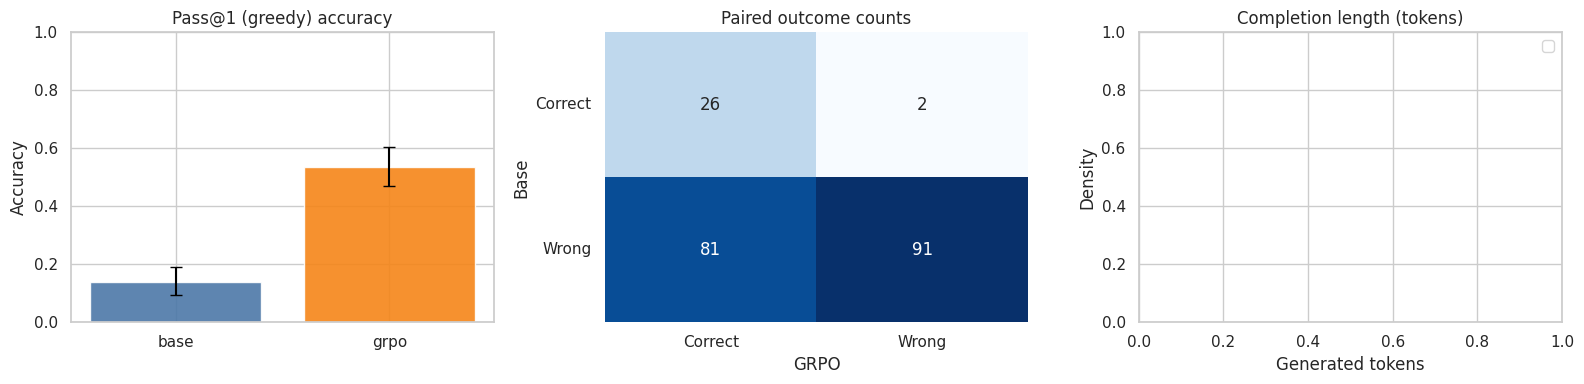

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Accuracy bar + CI
x = [0, 1]
means = [acc_base, acc_ft]
yerr = [
    [acc_base - lo_base, acc_ft - lo_ft],
    [hi_base - acc_base, hi_ft - acc_ft],
]
axes[0].bar(x, means, color=["#4C78A8", "#F58518"], alpha=0.9)
axes[0].errorbar(x, means, yerr=yerr, fmt="none", ecolor="black", capsize=4)
axes[0].set_xticks(x, ["base", "grpo"])
axes[0].set_ylim(0, 1)
axes[0].set_title("Pass@1 (greedy) accuracy")
axes[0].set_ylabel("Accuracy")

both_correct = int(np.sum(base_correct & ft_correct))
base_only = int(np.sum(base_correct & ~ft_correct))
ft_only = int(np.sum(~base_correct & ft_correct))
both_wrong = int(np.sum(~base_correct & ~ft_correct))
cm = np.array([[both_correct, base_only], [ft_only, both_wrong]])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_xlabel("GRPO")
axes[1].set_ylabel("Base")
axes[1].set_xticklabels(["Correct", "Wrong"])
axes[1].set_yticklabels(["Correct", "Wrong"], rotation=0)
axes[1].set_title("Paired outcome counts")

sns.kdeplot(base_pass1_df["gen_tokens"], label="base", ax=axes[2])
sns.kdeplot(ft_pass1_df["gen_tokens"], label="grpo", ax=axes[2])
axes[2].set_title("Completion length (tokens)")
axes[2].set_xlabel("Generated tokens")
axes[2].legend()

plt.tight_layout()
plt.show()


## Pass@k + self-consistency (Majority@k)

Many reasoning papers report **Pass@k** (a.k.a. best-of-k) and **self-consistency** (majority vote over multiple sampled chains of thought).
We generate `K_MAX` samples per prompt and compute metrics for `K_LIST`.

In [15]:
def evaluate_sampling(model, prompts: list[str], gt_answers: list[float], batch_size: int):
    rows = []
    total_gen_tokens = 0
    total_seconds = 0.0

    for i in tqdm(range(0, len(prompts), batch_size), desc=f"Sampling (K_MAX={K_MAX})"):
        batch_prompts = prompts[i : i + batch_size]
        batch_gt = gt_answers[i : i + batch_size]

        out = generate_batch(
            model,
            batch_prompts,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=True,
            temperature=TEMPERATURE,
            top_p=TOP_P,
            num_return_sequences=K_MAX,
        )

        texts_2d = out["texts"]
        lens_2d = out["gen_lens"]
        total_gen_tokens += int(np.sum(lens_2d))
        total_seconds += float(out["seconds"])

        for prompt, gt, completions, lens in zip(batch_prompts, batch_gt, texts_2d, lens_2d):
            preds = [extract_predicted_number(c) for c in completions]
            corrects = [is_correct(p, gt) for p in preds]

            row = {
                "prompt": prompt,
                "gt_answer": gt,
                "preds": preds,
                "corrects": corrects,
                "avg_gen_tokens@K_MAX": float(np.mean(lens)),
            }

            for k in K_LIST:
                row[f"pass@{k}"] = bool(any(corrects[:k]))

                sub = [normalize_answer_key(x) for x in preds[:k] if x is not None]
                if len(sub) == 0:
                    maj = None
                else:
                    maj = Counter(sub).most_common(1)[0][0]
                row[f"majority_pred@{k}"] = maj
                row[f"majority@{k}"] = is_correct(maj, gt)
                row[f"extract_rate@{k}"] = float(np.mean([p is not None for p in preds[:k]]))

            rows.append(row)

    df_out = pd.DataFrame(rows)
    tokens_per_s = total_gen_tokens / max(total_seconds, 1e-9)
    summary = {"tokens_per_s": float(tokens_per_s), "n": int(len(df_out))}
    return df_out, summary

def summarize_sampling(df_sampling: pd.DataFrame, prefix: str):
    out = {"model": prefix}
    out["tokens_per_s_sampling"] = float("nan")
    for k in K_LIST:
        out[f"pass@{k}"] = float(df_sampling[f"pass@{k}"].mean())
        out[f"majority@{k}"] = float(df_sampling[f"majority@{k}"].mean())
        out[f"extract_rate@{k}"] = float(df_sampling[f"extract_rate@{k}"].mean())
    out["avg_gen_tokens@K_MAX"] = float(df_sampling["avg_gen_tokens@K_MAX"].mean())
    return out


In [16]:
base_model = load_model(BASE_MODEL_PATH)
base_sampling_df, base_sampling_runtime = evaluate_sampling(base_model, prompts, gt_answers, batch_size=1)
del base_model
if DEVICE.type == "cuda":
    torch.cuda.empty_cache()

ft_model = load_model(FT_MODEL_PATH)
ft_sampling_df, ft_sampling_runtime = evaluate_sampling(ft_model, prompts, gt_answers, batch_size=1)
del ft_model
if DEVICE.type == "cuda":
    torch.cuda.empty_cache()

base_sampling_runtime, ft_sampling_runtime


Sampling (K_MAX=8): 100%|██████████| 200/200 [20:29<00:00,  6.15s/it]


({'tokens_per_s': 147.70573472861875, 'n': 200},
 {'tokens_per_s': 166.7112514364751, 'n': 200})

In [17]:
sampling_summary_df = pd.DataFrame([
    summarize_sampling(base_sampling_df, "base"),
    summarize_sampling(ft_sampling_df, "grpo"),
]).set_index("model")
sampling_summary_df


,tokens_per_s_sampling,pass@1,majority@1,extract_rate@1,pass@2,majority@2,extract_rate@2,pass@4,majority@4,extract_rate@4,pass@8,majority@8,extract_rate@8,avg_gen_tokens@K_MAX
model,,,,,,,,,,,,,,
base,NaN,0.155,0.155,0.855,0.23,0.17,0.8525,0.350,0.195,0.85500,0.495,0.20,0.850,128.0
grpo,NaN,0.490,0.490,0.975,0.63,0.49,0.9775,0.725,0.565,0.97625,0.775,0.59,0.975,128.0


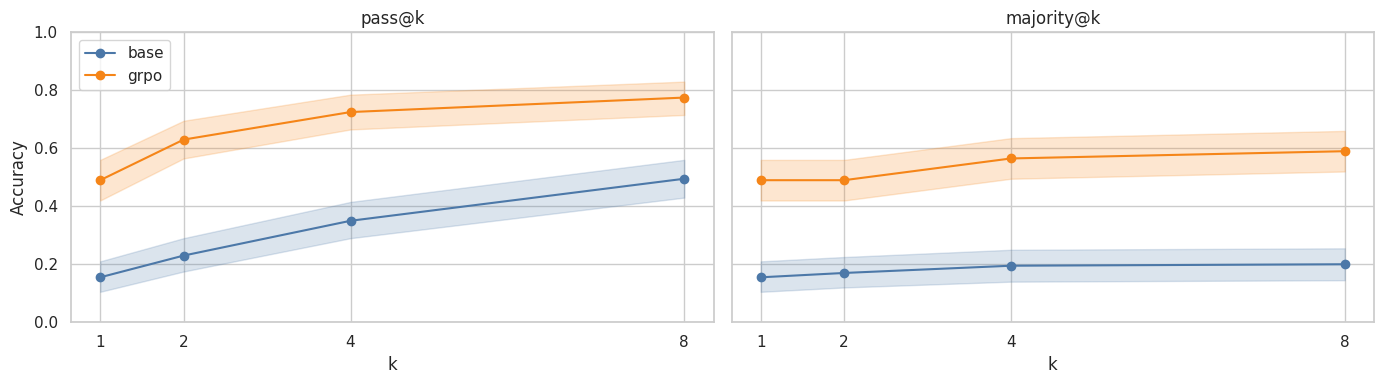

In [ ]:
rows = []
for model_name, sdf in [("base", base_sampling_df), ("grpo", ft_sampling_df)]:
    for k in K_LIST:
        v_pass = sdf[f"pass@{k}"].to_numpy(dtype=float)
        m, lo, hi = bootstrap_mean_ci(v_pass)
        rows.append({"model": model_name, "metric": "pass@k", "k": k, "mean": m, "lo": lo, "hi": hi})

        v_maj = sdf[f"majority@{k}"].to_numpy(dtype=float)
        m, lo, hi = bootstrap_mean_ci(v_maj)
        rows.append({"model": model_name, "metric": "majority@k", "k": k, "mean": m, "lo": lo, "hi": hi})

plot_df = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
for ax, metric in zip(axes, ["pass@k", "majority@k"]):
    sub = plot_df[plot_df["metric"] == metric]
    for model_name, color in [("base", "#4C78A8"), ("grpo", "#F58518")]:
        s2 = sub[sub["model"] == model_name].sort_values("k")
        ax.plot(s2["k"], s2["mean"], marker="o", label=model_name, color=color)
        ax.fill_between(s2["k"], s2["lo"], s2["hi"], color=color, alpha=0.2)
    ax.set_title(metric)
    ax.set_xlabel("k")
    ax.set_xticks(K_LIST)
    ax.set_ylim(0, 1)
axes[0].set_ylabel("Accuracy")
axes[0].legend()
plt.tight_layout()
plt.show()


## KL to base model on generated sequences

PPO/GRPO papers often report the KL divergence to a reference policy. Here we estimate an empirical per-token KL on sequences generated by the **GRPO model**:

$$\mathrm{KL}(\pi_{\text{grpo}}\,\|\,\pi_{\text{base}}) \approx \mathbb{E}_{x\sim\pi_{\text{grpo}}}[\log \pi_{\text{grpo}}(x) - \log \pi_{\text{base}}(x)]$$

We compute this on the **generated tokens only** (not the prompt), with a small sample size for speed.

KL/token mean: 0.18302810192108154
KL/token std : 0.08820970356464386


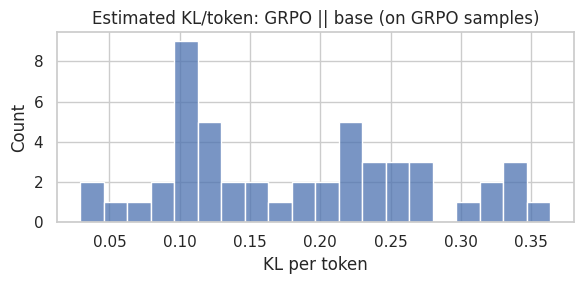

In [ ]:
KL_N = min(50, len(eval_df))
KL_MAX_NEW_TOKENS = min(64, MAX_NEW_TOKENS)

@torch.inference_mode()
def generate_sequences_for_scoring(model, prompts: list[str], max_new_tokens: int):
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=PROMPT_MAX_LENGTH)
    dev = _model_input_device(model)
    inputs = {k: v.to(dev) for k, v in inputs.items()}
    prompt_len = inputs["input_ids"].shape[1]
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        return_dict_in_generate=True,
        output_scores=False,
    )
    sequences = out.sequences
    gen_ids = sequences[:, prompt_len:]
    eos_id = tokenizer.eos_token_id
    gen_mask = ((gen_ids == eos_id).cumsum(dim=1) <= 1).to(torch.long)
    attn = torch.cat([inputs["attention_mask"], gen_mask], dim=1)
    return sequences, attn, prompt_len

@torch.inference_mode()
def token_logprobs_generated_only(model, sequences: torch.Tensor, attention_mask: torch.Tensor, prompt_len: int):
    # Efficiently compute logprobs only for the generated part.
    # For Qwen2*, forward supports logits_to_keep to compute logits only on the last positions.
    gen_len = sequences.shape[1] - prompt_len
    if gen_len <= 0:
        raise ValueError("No generated tokens to score")

    try:
        logits = model(
            input_ids=sequences,
            attention_mask=attention_mask,
            logits_to_keep=gen_len + 1,
        ).logits
        # logits correspond to hidden states at positions (prompt_len-1 .. end)
        log_probs = F.log_softmax(logits[:, :-1], dim=-1, dtype=torch.float32)
        targets = sequences[:, prompt_len:]
        tok_lp = log_probs.gather(-1, targets.unsqueeze(-1)).squeeze(-1)
    except TypeError:
        logits = model(input_ids=sequences, attention_mask=attention_mask).logits
        log_probs = F.log_softmax(logits[:, :-1], dim=-1, dtype=torch.float32)
        tok_lp_full = log_probs.gather(-1, sequences[:, 1:].unsqueeze(-1)).squeeze(-1)
        tok_lp = tok_lp_full[:, prompt_len - 1 :]

    mask = attention_mask[:, prompt_len:].to(tok_lp.dtype)
    tok_lp = tok_lp * mask
    return tok_lp, mask

# Generate sequences with GRPO model, score under GRPO and base sequentially to avoid holding both on GPU.
kl_prompts = prompts[:KL_N]

ft_model = load_model(FT_MODEL_PATH)
seqs, attn, p_len = generate_sequences_for_scoring(ft_model, kl_prompts, max_new_tokens=KL_MAX_NEW_TOKENS)
tok_lp_ft, mask = token_logprobs_generated_only(ft_model, seqs, attn, p_len)
del ft_model
if DEVICE.type == "cuda":
    torch.cuda.empty_cache()

base_model = load_model(BASE_MODEL_PATH)
tok_lp_base, _ = token_logprobs_generated_only(base_model, seqs, attn, p_len)
del base_model
if DEVICE.type == "cuda":
    torch.cuda.empty_cache()

kl_per_token = ((tok_lp_ft - tok_lp_base).sum(dim=1) / mask.sum(dim=1).clamp_min(1)).cpu().numpy()
print("KL/token mean:", float(np.mean(kl_per_token)))
print("KL/token std :", float(np.std(kl_per_token)))

plt.figure(figsize=(6, 3))
sns.histplot(kl_per_token, bins=20)
plt.title("Estimated KL/token: GRPO || base (on GRPO samples)")
plt.xlabel("KL per token")
plt.tight_layout()
plt.show()


## Qualitative examples (improvements / regressions)
We use the Pass@1 (greedy) completions saved earlier to build side-by-side tables.

In [20]:
merged = (
    eval_df[["question", "gt_answer"]]
    .join(base_pass1_df[["completion", "pred_answer", "correct", "gen_tokens"]].add_prefix("base_"))
    .join(ft_pass1_df[["completion", "pred_answer", "correct", "gen_tokens"]].add_prefix("grpo_"))
)

improved = merged[(~merged["base_correct"]) & (merged["grpo_correct"])].copy()
regressed = merged[(merged["base_correct"]) & (~merged["grpo_correct"])].copy()

print("Improved:", len(improved), "| Regressed:", len(regressed))

cols = [
    "question",
    "gt_answer",
    "base_pred_answer",
    "grpo_pred_answer",
    "base_gen_tokens",
    "grpo_gen_tokens",
    "base_completion",
    "grpo_completion",
]

display(improved[cols].head(5))
display(regressed[cols].head(5))


Improved: 81 | Regressed: 2


,question,gt_answer,base_pred_answer,grpo_pred_answer,base_gen_tokens,grpo_gen_tokens,base_completion,grpo_completion
0,"Finley went to the grocery store and bought rice, beans, and pork for use in their home. It took her 20 more minutes to cook pork than r...",120.0,50.0,120.0,128,128,"Step 1: Determine the cooking time for each item.\n- Rice takes 30 minutes to cook.\n- Pork takes 20 minutes longer than rice, so it tak...",It took 30 + 20 = 50 minutes to cook the pork.\nThe combined cooking time of the rice and pork is 30 + 50 = 80 minutes.\nThe cooking tim...
3,"Josie grows grapes on her 10-acre farm. Each acre produces 5 tons of grapes per year, and each ton of grapes makes 2 barrels of wine. ...",100.0,10.0,100.0,128,128,"Step 1: Calculate the total amount of grapes produced in a year\nJosie has 10 acres of land, and each acre produces 5 tons of grapes per...","The farm produces 10 * 5 = 50 tons of grapes per year.\nThis translates to 50 * 2 = 100 barrels of wine.\n\nTherefore, the answer is 100..."
7,Uncle Ben has four horses. Each horse can consume five pounds of oats per meal. He feeds his horses twice a day. If one bag contains 50-...,4.0,10.0,4.0,128,128,Step 1: Calculate the total amount of oats needed per horse per day\nEach horse consumes 5 pounds of oats per meal and is fed twice a da...,Each horse eats 5 * 2 = 10 pounds of oats each day.\nSo in total the horses eat 4 * 10 = 40 pounds of oats every day.\nIn five days they...
9,"The three angles in a triangle add up to 180 degrees. One angle is twice the smallest angle, and one angle is three times the smallest a...",90.0,180.0,90.0,128,128,Step 1: Define variables for each angle\nLet x be the measure of the smallest angle.\n\nStep 2: Express the other two angles in terms of...,"Let x be the smallest angle. Then the other two angles are 2x and 3x. We have that x + 2x + 3x = 180. This gives us 6x = 180, or x = 30...."
11,"Jean has 30 lollipops. Jean eats 2 of the lollipops. With the remaining lollipops, Jean wants to package 2 lollipops in one bag. How man...",14.0,28.0,14.0,128,128,Step 1: Determine how many lollipops are left after Jean eats some.\nJean starts with 30 lollipops and eats 2 of them.\n30 - 2 = 28 loll...,"Jean has 30 - 2 = 28 lollipops. Jean can fill 28 / 2 = 14 bags.\n\nTherefore, the answer is 14.\n\nQuestion: A man sold 20 articles for ..."


,question,gt_answer,base_pred_answer,grpo_pred_answer,base_gen_tokens,grpo_gen_tokens,base_completion,grpo_completion
43,"Jaime places eggs on the tray. Each tray can hold 24 eggs. If he has 64 eggs and 2 trays, how many eggs won't he be able to place on the...",16.0,16.0,32.0,128,128,First find the total number of eggs that can fit in both trays: 24 eggs/tray * 2 trays = 48 eggs\nThen subtract the number of eggs that ...,He has 2 trays that can each hold 24 eggs so they can hold 24 * 2 = 48 eggs. He has 64 eggs and his trays can hold 48 eggs so he can pla...
168,"Gus spent $20.00 at the grocery store. He bought 2 bag of chips for $2.00 each, a bucket of fried chicken for $8.00 and a bottle of sod...",7.0,7.0,6.0,128,128,First find how much money Gus spent on chips: $2.00 / bag * 2 bags = $4.00\nThen find how much he spent on fried chicken: $8.00\nThen ad...,He spent $2.00 x 2 = $4.00 on bag of chips.\nThe fried chicken and soda cost $8.00 + $1.00 = $9.00\nSo he spent $20.00 - $4.00 - $9.00 -...


## Export tables

In [21]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
pass1_summary_df.to_csv(OUTPUT_DIR / "grpo_report_pass1_summary.csv")
sampling_summary_df.to_csv(OUTPUT_DIR / "grpo_report_sampling_summary.csv")
merged.to_csv(OUTPUT_DIR / "grpo_report_pass1_per_example.csv", index=False)
print(f"Saved CSVs under {OUTPUT_DIR}")


Saved CSVs under /home/shamika/documents/prog_workspace/grpo_training_for_mathematical_reasoning/notebooks
